## Encode variant as an image

To train the Neural Network, we must encode information about each candidate variant. Relevant data will be composed of refererence and read sequences, read quality scores, read flags. We shall encode the relevant information of each variant from the VCF file using a 14-channel image.

To encode variant data, we need a VCF file with variants, corresponding BAM file with aligned reads and the FASTA file of the reference genome. We prepared three toy files, with some variants withdrawn from the latest Genome in a Bottle release v. 3.3.2.

Initial high-confidence VCF file: https://ftp-trace.ncbi.nlm.nih.gov/ReferenceSamples/giab/release/NA12878_HG001/NISTv3.3.2/GRCh38/HG001_GRCh38_GIAB_highconf_CG-IllFB-IllGATKHC-Ion-10X-SOLID_CHROM1-X_v.3.3.2_highconf_PGandRTGphasetransfer.vcf.gz

Initial BAM file:  https://ftp-trace.ncbi.nlm.nih.gov/ReferenceSamples/giab/data/NA12878/10Xgenomics_ChromiumGenome_LongRanger2.1_09302016/NA12878_GRCh38/NA12878_GRCh38_phased_possorted_bam.bam

In [ ]:
import numpy as np
import sys

import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
!pip install pysam #python library to read VCF(variant calls) and SAM(BAM) (aligned reads) files

import pysam 

     |████████████████████████████████| 9.9 MB 15.3 MB/s 


In [ ]:
#Get tutorial data

!wget -O data.tar 'https://drive.google.com/uc?export=download&id=1aBsEZ_I8JEKG0hL82xAnnWdAFW34Owhp'
!tar -xvf data.tar

--2021-08-23 13:46:19--  https://drive.google.com/uc?export=download&id=1aBsEZ_I8JEKG0hL82xAnnWdAFW34Owhp
Resolving drive.google.com (drive.google.com)... 108.177.127.139, 108.177.127.102, 108.177.127.138, ...
Connecting to drive.google.com (drive.google.com)|108.177.127.139|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0s-04-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/b40abbesis2eaiufd3lu1mbgltc1saaq/1629726375000/16545205334574304565/*/1aBsEZ_I8JEKG0hL82xAnnWdAFW34Owhp?e=download [following]
--2021-08-23 13:46:20--  https://doc-0s-04-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/b40abbesis2eaiufd3lu1mbgltc1saaq/1629726375000/16545205334574304565/*/1aBsEZ_I8JEKG0hL82xAnnWdAFW34Owhp?e=download
Resolving doc-0s-04-docs.googleusercontent.com (doc-0s-04-docs.googleusercontent.com)... 108.177.119.132, 2a00:1450:4013:c07::84
Connecting to doc-0s-04-docs.googleusercontent.com (d

In [ ]:
sys.path.append('utils/')
from variant_to_image_helpers import * #some helper functions

In [ ]:
#toy reference FASTA files
ref_fasta_file = 'data/raw/GRCh38_extract.fa'
#toy experiment BAM file
bam_file = 'data/raw/NA12878_GRCh38_phased_possorted_extract.bam'
#toy VCF file with candidate variants
vcf_file = 'data/raw/HG001_GRCh38_GIAB_highconf_CG-IllFB-IllGATKHC-Ion-10X-SOLID_CHROM1-X_v.3.3.2_highconf_PGandRTGphasetransfer_first_ten.vcf.gz'

We shall open the VCF file and take a look at the first 10 variants  using the pysam fetch() method. We will then make an image for the last (10th) variant.

In [ ]:
vcf = pysam.VariantFile(vcf_file)

variants_itr = vcf.fetch() #iterator over all variants in the VCF

#display the first 10 variants in the VCF

for i in range(10):
    variant = next(variants_itr)
    variant = dict(chrom=variant.chrom, pos=variant.pos, ref=variant.ref, alt=variant.alts[0]) #VariantRecord to dict
    print(f"CHROM: {variant['chrom']}, POS: {variant['pos']} REF: {variant['ref']} ALT: {variant['alt']}")

CHROM: chr1, POS: 817186 REF: G ALT: A
CHROM: chr1, POS: 817341 REF: A ALT: G
CHROM: chr1, POS: 817889 REF: C ALT: G
CHROM: chr1, POS: 818025 REF: C ALT: A
CHROM: chr1, POS: 818802 REF: A ALT: G
CHROM: chr1, POS: 818812 REF: A ALT: G
CHROM: chr1, POS: 818954 REF: T ALT: C
CHROM: chr1, POS: 819123 REF: G ALT: A
CHROM: chr1, POS: 819584 REF: C ALT: T
CHROM: chr1, POS: 824320 REF: T ALT: C


<span style="color:red"> Now we will open the BAM file to collect all reads around the candidate variant position. We can already exclude some reads on-the-fly by filtering using some SAM flags. Which flags can we use? See specification of the SAM format here: https://samtools.github.io/hts-specs/SAMv1.pdf </span>

In [ ]:
EXCLUDE_FLAGS = 0x4|0x200|0x400

<span style="color:red"> We also need a function that convert the ANCII quality symbols to the probability that the base is called INCORRECTLY.</span>

In [ ]:
def get_phred_qual(qual_symbol):
    '''
    Return the probability that the base is called incorrectly
    
    Input: ANCII quality character
    Output: Probability
    '''
    qual_number = ord(qual_symbol)-33

    probability = 10**-(qual_number/10)
    
    return probability

In [ ]:
bam = pysam.AlignmentFile(bam_file, "rb" ) 

#collect all the reads around the candidate variant position

raw_reads = []

for read in bam.fetch(variant['chrom'], variant['pos']-1, variant['pos']+1):
    
    if (read.pos<=variant['pos']-1 and read.pos+read.rlen>variant['pos']-1 and 
        read.flag&EXCLUDE_FLAGS==0 
       ):
            
            qual = np.array([get_phred_qual(q) for q in read.qual])     #probability that the base is called INCORRECTLY
            qual = 1.-qual                                              #probability that the base is called CORRECTLY
            
            #for each read save absolute position, sequence, quality scores, flags and CIGAR string
            raw_reads.append((read.pos,read.seq,qual,read.flag,read.cigartuples)) 

In [ ]:
raw_reads

In [ ]:
IMAGE_HEIGHT = 70 #image height

IMAGE_WIDTH = 150 # image width

Let's get reference bases around the variant position. 

In [ ]:
#get the original reference sequence from the fasta file, variant being roughly in the center

variant_chromosome = variant['chrom']

variant_position = variant['pos']

variant_column = IMAGE_WIDTH//2 #variant column index

#ref_fasta = pysam.FastaFile(ref_fasta_file) #normal pysam FASTA reader
ref_fasta = FastaFile(ref_fasta_file)        #simulated FASTA reader, for this tutorial

'chr1'

<span style="color:red"> We can again use the pysam fetch() method to get the references bases.
How shall we get a sequence of IMAGE_WIDTH reference bases s.t. the variant position is roughly at the center? </span>

In [ ]:
ref_bases = ref_fasta.fetch(variant_chromosome,variant_position-variant_column-1,variant_position-variant_column+IMAGE_WIDTH-1) 

ref_bases = list(ref_bases)

print(''.join(ref_bases)) #list to string

ref_bases = np.array(list(map(encode_bases,ref_bases))) # letters to digits

ATATTTAAACTACAGAATATAAAATAGCATCTAATATACATCAAAAATGAGTTTCATAGAAAAATTCATTTTACATATATGTCTATAAAATAATAAAATTTATTCAGCCTCACAATTACTTTGTGAACTGGAAATAACAATGAGTTGTCA


In [ ]:
encode_bases

<function variant_to_image_helpers.encode_bases>

Now let's see what happens when we take the reads as they are. 

In [ ]:
N_reads = len(raw_reads)

reads_im = np.zeros((N_reads,IMAGE_WIDTH,1)) #pileup image of all reads centered at the variant

for read_idx,read in enumerate(raw_reads):
    
    pos,seq = read[:2] #absolute position and sequence of the read
    
    seq = encode_bases(seq) # read sequence encoding: letters to digits  
    
    start_pos = pos-(variant['pos']-1-variant_column) #relative position of the read in the pileup image
    
    if start_pos<0: seq = seq[-start_pos:] #reject the data that's beyond the left image edge
        
    start_pos = max(start_pos,0)

    reads_im[read_idx,start_pos:start_pos+len(seq),0] = seq[:IMAGE_WIDTH-start_pos]
    
show_diff_text(reads_im, ref_bases)

GTTTCATAGAAAAATTCATTTTACATATATGTCTATAAAATAATAAAATT
GTTTAATAGAAAAATTCAGTTTAAATATATATAAAAAAAAAAAAAAAAAA
GTTTCATAGAAAAATTCATTTTACACATATGTCAAAAAAAAAAAAAAAAA
GTTTCATAGAATAATTCATCTTACACATATGTCTATAAAAAAAAAAAAAA
GTTTCATAGAAAAATTCATTTTACACATATGTCTATAAAATAAAAAAAAA
GAGTTTCATAGAAAAATTCATTTTACACATATGTCTATAAAATAATAAAA
AGTTTCATAGAAAAAAAAATTCATTTTACACATATGTCTATAAAATAATA
GTTTCATAGAAAAATTCATTTTACACATATGTCTATAAAATAATAAAATT
GTTTCATAGAAAAATTCATTTTACACATATGTCTATAAAATAATAAAATT
ATATACATCAAAAATGAGTTTCATAGAAAAATTCATTTTACACATATGTC
TATACATCAAAAATGAGTTTCATAGAAAAATTCATTTTACACATATAAAA
GTTTCATAGAAAAATTCATTTTACACATATGTCTATAAATTTTATTATTT
GTTTCATAGAAAAATTCATTTTACACATATGTCTATAAAATAATAAAATT
TCTAATATACATCAAAAATGAGTTTCATAGAAAAATTCATTTTACACATA
GTTTCATAGAAAAATTCATTTTACACATATGTCTATAAAATAATAAAATT
GTTTCATAGAAAAATTCATTTTACACATATGTCTATAAAATAATAAAATT
GTTTCATAGAAAAATTCATTTTACACATATGTCAATAAAATAATAAAATT
AAAATAGCATCTAATATACATCAAAAATGAGTTTCATAGAAAAATTCATT
GTTTCATAGAAAAATTCATTTTACACATATGTCTATAAAATAATAAAATT
GTTTCATAGAAAAATTCATTTTACACATATG

<span style="color:red"> Why do some reads look unmapped? </span>

In [ ]:
#Align reads according to their CIGAR strings.

#For each read the cigar string is analysed to place read bases correctly (taking into account clips, insertions,deletion).

aligned_reads = []

for read_idx, read in enumerate(raw_reads):
    
    pos,seq,qual,flag,cigartuples = read
        
    aligned_seq = []  #aligned read sequence
    aligned_qual = [] #aligned read qualities
    
    seq = encode_bases(seq) # read sequence encoding: letters to digits  
    
    c = 0 #current position in the original (not aligned) read
    
    #we move along the original read sequence and make insertions/delections when necessary
    for op in cigartuples:
        optype, oplen = op #type and length of cigar operation
        if optype==5:#hard clip:do nothing as it's not included in seq
            continue
        elif optype==4:#soft clip: exclude these positions from aligned seq as they aren't used by callers
            c+=oplen
        elif optype==2 or optype==3 or optype==6: #deletion or padding
            aligned_seq.extend([encode_bases('*')]*oplen)
            aligned_qual.extend([0]*oplen)
        elif optype==1:#insertion
            c+=oplen
        else: #match or mismatch
            aligned_seq.extend(seq[c:c+oplen])
            aligned_qual.extend(qual[c:c+oplen])  
            c+=oplen
            
    #length of aligned sequence may differ from length of the original sequence : we must make sure that we still cover the variant site
    if  pos+len(aligned_seq)>variant['pos']-1: 
        
        aligned_reads.append((pos,aligned_seq,aligned_qual,flag))
            
N_reads = len(aligned_reads)

In [ ]:
reads_im = np.zeros((N_reads,IMAGE_WIDTH,2)) # 2 channels to encode sequence and probability of each read base

reads_im[:,:,0] = encode_bases('N') #bases for all reads, default: no data ('N')
reads_im[:,:,1] = 1/4. #probability to have the corresponding basis, default:equal probability of all bases

variant_column = IMAGE_WIDTH//2 

for read_idx, read in enumerate(aligned_reads):
    
    pos,seq,qual,flag = read #absolute position, sequence, quality scores and flags of the read
        
    start_pos = pos-(variant['pos']-1-variant_column) #relative position of the read in the image
    
    if start_pos<0: #left end of the read is beyond the defined image edge
        
        #reject data that's beyond the image
        seq = seq[-start_pos:]
        qual = qual[-start_pos:]
        start_pos = 0
        
    rlen = len(seq)
    
    reads_im[read_idx,start_pos:start_pos+rlen,0] = seq[:IMAGE_WIDTH-start_pos]
    reads_im[read_idx,start_pos:start_pos+rlen,1] = qual[:IMAGE_WIDTH-start_pos]

In [ ]:
show_diff_text(reads_im, ref_bases)

GTTTCATAGAAAAATTCATTTTACATATATGTCTATAAAATAATAAAATT
GTTTAATAGAAAAATTCAGTTTAAATATATATNNNNNNNNNNNNNNNNNN
GTTTCATAGAAAAATTCATTTTACACATATGTCANNNNNNNNNNNNNNNN
GTTTCATAGAATAATTCATCTTACACATATGTCTATAANNNNNNNNNNNN
GTTTCATAGAAAAATTCATTTTACACATATGTCTATAAAATNNNNNNNNN
GTTTCATAGAAAAATTCATTTTACACATATGTCTATAAAATAATANNNNN
GTTTCATAGAAAAATTCATTTTACACATATGTCTATAAAATAATNNNNNN
GTTTCATAGAAAAATTCATTTTACACATATGTCTATAAAATAATAAAATT
GTTTCATAGAAAAATTCATTTTACACATATGTCTATAAAATAATAAAATT
GTTTCATAGAAAAATTCATTTTACACATATGTCTATAAANNNNNNNNNNN
GTTTCATAGAAAAATTCATTTTACACATATNNNNNNNNNNNNNNNNNNNN
GTTTCATAGAAAAATTCATTTTACACATATGTCTATAAANNNNNNNNNNN
GTTTCATAGAAAAATTCATTTTACACATATGTCTATAAAATAATAAAATT
GTTTCATAGAAAAATTCATTTTACACATATGTCTATAAAATAATAAAATT
GTTTCATAGAAAAATTCATTTTACACATATGTCTATAAAATAATAAAATT
GTTTCATAGAAAAATTCATTTTACACATATGTCTATAAAATAATAAAATT
GTTTCATAGAAAAATTCATTTTACACATATGTCAATAAAATAATAAAATT
GTTTCATAGAAAAATTCATTTTACACATATGTNNNNNNNNNNNNNNNNNN
GTTTCATAGAAAAATTCATTTTACACATATGTCTATAAAATAATAAAATT
GTTTCATAGAAAAATTCATTTTACACATATG

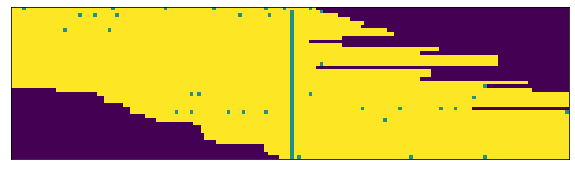

In [ ]:
show_diff_image(reads_im, ref_bases)

reads_im[:,:,0] (N_reads x width) contains sequences for all reads

reads_im[:,:,1] (N_reads x width) contains probabilities for all reads

we shall create an array p_hot_reads that will contain probabilities for ALL bases (ACTG) at EACH read position.
i.e. if we read 'A' and the corresponding probability is 0.99, we assign the probability (1-0.99)/3 to all the other 3 bases.

<div style="color:red">  We shall now fill p_hot_reads (N_reads x IMAGE_WIDTH x 4) based on reads_im. <br>
    Examples:<br>
    p_hot_reads[3,4,0] gives the probability that for the 3rd read in position 4 the base is 'A' <br>
    p_hot_reads[0,1,3] gives the probability that for the 0th read in position 1 the base is 'G'

</div> 

In [ ]:
p_hot_reads = np.zeros((N_reads,IMAGE_WIDTH,4)) # p-hot encoding of reads probabilities: each channel gives the probability of the corresponding base (ACTG)

for basis_idx in range(4): 
    #basis_idx 0:A 1:C 2:T 3:G
    p_hot_reads[:,:,basis_idx] = np.where(reads_im[:,:,0]==basis_idx, reads_im[:,:,1], (1.-reads_im[:,:,1])/3.)

In [ ]:
one_hot_ref = np.zeros((1,IMAGE_WIDTH,4)) #one-hot encoding of reference bases, same for all reads

for basis_idx in range(4):
    one_hot_ref[:,(ref_bases==basis_idx),basis_idx] = 1.
    
flags_reads = np.zeros((N_reads,IMAGE_WIDTH,6)) # encoding of 6 flags, different for all reads

#loop over flags of all reads
for read_idx, (_,_,_,flag) in enumerate(aligned_reads):
    flags_reads[read_idx,:,0]=flag&0x2   #each segment properly aligned according to the aligner
    flags_reads[read_idx,:,1]=flag&0x8   #next segment unmapped
    flags_reads[read_idx,:,2]=flag&0x10  #SEQ being reverse complemented
    flags_reads[read_idx,:,3]=flag&0x20  #SEQ of the next segment in the template being reverse complemented
    flags_reads[read_idx,:,4]=flag&0x100 #secondary alignment
    flags_reads[read_idx,:,5]=flag&0x800 #supplementary alignment
    flags_reads[read_idx,:] = flags_reads[read_idx,:]>0 #to boolean

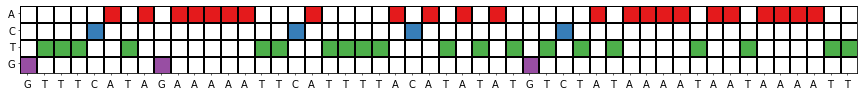

In [ ]:
#visualize reference channels (they are the same for all reads)

N_crop = 50 #bases to omit on each side of the variant position, to make lines shorter

from matplotlib.colors import ListedColormap

nucl_colors=np.array([(255,255,255), (228,26,28), (55,126,184), (77,175,74), (152,78,163)])/255. #colors for NACTG
nucl_cmap = ListedColormap(nucl_colors)

ref_im = np.transpose(one_hot_ref[0, N_crop:-N_crop,:]).copy().astype(np.ubyte) #reference tensor is the same for all reads, we choose read 0

for base_idx in range(4):
    ref_im[base_idx,:]=ref_im[base_idx,:]*(base_idx+1) #color corresponds to the base index  

ref_letters = decode_bases(ref_bases) #seqence decoding:map digits back to letters

pcolor(ref_im, yticklabels=['A','C','T','G'], xticklabels=ref_letters[N_crop:-N_crop], cmap=nucl_cmap, figsize = (15,15))

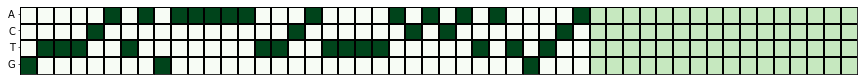

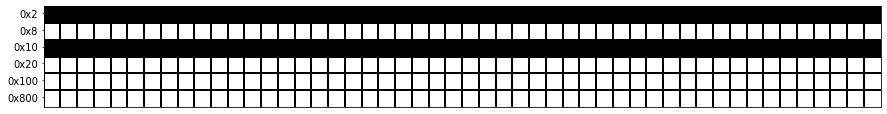

In [ ]:
#visualize channels specific to a given read

read_number = 1

N_crop = 50 #bases to omit on each side of the variant position, to make lines shorter

reads_letters = [list(map(lambda x:decode_bases(x), x)) for x in reads_im[:,0,:]] #seqence decoding:map digits back to letters

phreads_im = np.transpose(p_hot_reads[read_number,N_crop:-N_crop,:]).copy() 
pcolor(phreads_im, yticklabels=['A','C','T','G'], xticklabels=reads_letters[read_number][N_crop:-N_crop], cmap='Greens',figsize = (15,15))

flags_im = np.transpose(flags_reads[read_number,N_crop:-N_crop,:])
pcolor(flags_im, yticklabels=['0x2','0x8','0x10','0x20','0x100', '0x800'], xticklabels=reads_letters[read_number][N_crop:-N_crop], cmap='binary',figsize = (15,15))

In [ ]:
# How much memory does one image take?

import pickle

with open('test.img', 'wb') as f:
    pickle.dump({'one_hot_ref':one_hot_ref.astype(bool), 'p_hot_reads':p_hot_reads, 'flags_reads':flags_reads.astype(bool)},f)
    
!ls -alh test.img

-rw-r--r-- 1 root root 230K Aug 23 14:39 test.img
